# - Credict risk scoring - Proyect

## Logistic Regression

The main goal of this proyect is to apply machine learning to predict churn in a telecom company.

Imagine that we are working at a telecom company that offers phone and internet services, and we have a problem: some of our customers are churning. They no longer are using our services and are going to a different provider. We would like to prevent
that from happening, so we develop a system for identifying these customers and offer them an incentive to stay.

For that, we will apply a Logistic Regression model and we will analalize its performance.

## Table of Contents

- [**1. Reading and preparing data**](#ap1)

- [**2. Exploratory data analysis (EDA)**](#ap2)

    - 2.1. [Missing values](#ap2_1)
   
    - 2.2. [Distribution of the target variable](#ap2_2)

    - 2.3. [Feature distribution of values](#ap2_3)
    
    - 2.4. [Feature importance](#ap2_4)
        - 2.4.1. [Categorical variables](#ap2_4_1)
        - 2.4.2  [Numerical variables](#ap2_4_2)
 
- [**3. Feature enginering**](#ap3)

    - 3.1. [One hot encoding](#ap3_2)
    
- [**4. Training logistic regression**](#ap4)

- [**5. Model interpretation**](#ap5)

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, confusion_matrix, classification_report
from sklearn.feature_extraction import DictVectorizer

import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

from IPython.display import display

sns.set_style("darkgrid")

<a name="ap1"></a>
# 1. Reading and preparing data

In [46]:
df = pd.read_csv("churn.csv")

print("Number of examples: {}".format(len(df)))
df.head().T

Number of examples: 7043


,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


+ We see some white spaces and there are data in lower/upper case. 
+ Also, there are two variables whose correponding data type is not correct: Senior citizen: integer type (1/0) where it should be a string type; and Total Charges: object type when it should be a numeric type.
+ Target variable churn is a object type but in binary classification it should be a 1/0 output. 

In [6]:
df.SeniorCitizen = (df.SeniorCitizen == 1).astype(str)

df.columns = df.columns.str.lower().str.replace(" ", "_")

string_columns = list(df.dtypes[df.dtypes == "object"].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(" ", "_")
    
df.churn = (df.churn == "yes").astype(int)
    
df["totalcharges"] = pd.to_numeric(df["totalcharges"], errors = "coerce")
df["totalcharges"] = df["totalcharges"].fillna(0)

In [45]:
df.head().T

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,false,false,false,false,false
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   object 
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   phoneservice      7043 non-null   object 
 7   multiplelines     7043 non-null   object 
 8   internetservice   7043 non-null   object 
 9   onlinesecurity    7043 non-null   object 
 10  onlinebackup      7043 non-null   object 
 11  deviceprotection  7043 non-null   object 
 12  techsupport       7043 non-null   object 
 13  streamingtv       7043 non-null   object 
 14  streamingmovies   7043 non-null   object 
 15  contract          7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


Splitting our dataset into two parts: train and test sets. We delete out target variable from the dataset to avoid using it on the training step.

In [9]:
X = df.drop(columns = ["churn"], axis = 1)
y = df["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [ ]:
scores = []
kfold = KFold(n_splits = 10, shuffle = True, random_state = 1)

for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index] 

<a name="ap2"></a>
# 2. Exploratory data analysis (EDA)

<a name="ap2_1"></a>
## 2.1. Missing values

In [172]:
df_train_full.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

<a name="ap2_2"></a>
## 2.2. Distribution of the target variable

+ As we can see the mayority of the customers did not churn.
+ We have an imbalanced dataset, there are three times as many people who did not churn as those who did churn.

In [34]:
global_mean = round(df["churn"].mean(), 2)
print("Churn rate: {}".format(global_mean))

Churn rate: 0.27


0    5174
1    1869
Name: churn, dtype: int64

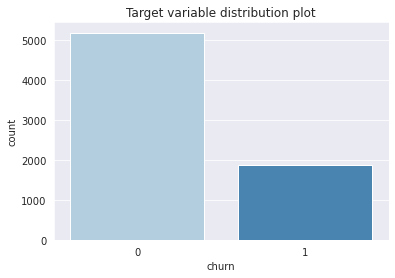

In [29]:
plt.figure(figsize = (6,4))

sns.countplot(data = df, x = "churn", palette = "Blues")
plt.title("Target variable distribution plot")

df["churn"].value_counts()

<a name="ap2_3"></a>
## 2.3. Feature distribution of values 

Categorical and numerical data have different treatment so we need to know witch series correspond with these types od data.

In [42]:
catCols = list(X.select_dtypes(include = "object").columns)
print("There are {} categorical variables: \n{}".format(len(catCols), catCols))

There are 17 categorical variables: 
['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']


In [43]:
numCols = list(X.select_dtypes(exclude = "object").columns)
print("There are {} numerical variables: \n{}".format(len(numCols), numCols))

There are 3 numerical variables: 
['tenure', 'monthlycharges', 'totalcharges']


We see that most of the columns have between one and four values. This is good. We don’t need to spend extra time preparing and cleaning the data; everything is already good to go.

In [176]:
df_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

### 2.4. Feature importance

### 2.4.1. Categorical variables

### + Churn rate

From the results we learn that:
+ For gender, there is not much difference between females and males. Both means are approximately the same, and for both groups the risks are close to 1.
+ Senior citizens tend to churn more than nonseniors: the risk of churning is 1.53 for seniors and 0.89 for nonseniors.
+ People with a partner churn less than people with no partner. The risks are 0.75 and 1.22, respectively.
+ People who use phone service are not at risk of churning: the risk is close to 1, and there’s almost no difference with the global churn rate. People who don’t use phone service are even less likely to churn: the risk is below 1, and the difference with the global churn rate is negative.
+ Clients with no tech support tend to churn more than those who do.
+ People with monthly contracts cancel the contract a lot more often than others, and people with two-year contacts churn very rarely.

In [177]:
for col in categorical:
    df_group = df_train_full.groupby(by = col).churn.agg(["mean"])
    df_group["diff"] = df_group["mean"] - global_mean
    df_group["risk"] = df_group["mean"] / global_mean
    display(df_group)

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


,mean,diff,risk
seniorcitizen,,,
false,0.242270,-0.027698,0.897403
true,0.413377,0.143409,1.531208


,mean,diff,risk
partner,,,
no,0.329809,0.059841,1.221659
yes,0.205033,-0.064935,0.759472


,mean,diff,risk
dependents,,,
no,0.313760,0.043792,1.162212
yes,0.165666,-0.104302,0.613651


,mean,diff,risk
phoneservice,,,
no,0.241316,-0.028652,0.893870
yes,0.273049,0.003081,1.011412


,mean,diff,risk
multiplelines,,,
no,0.257407,-0.012561,0.953474
no_phone_service,0.241316,-0.028652,0.893870
yes,0.290742,0.020773,1.076948


,mean,diff,risk
internetservice,,,
dsl,0.192347,-0.077621,0.712482
fiber_optic,0.425171,0.155203,1.574895
no,0.077805,-0.192163,0.288201


,mean,diff,risk
onlinesecurity,,,
no,0.420921,0.150953,1.559152
no_internet_service,0.077805,-0.192163,0.288201
yes,0.153226,-0.116742,0.567570


,mean,diff,risk
onlinebackup,,,
no,0.404323,0.134355,1.497672
no_internet_service,0.077805,-0.192163,0.288201
yes,0.217232,-0.052736,0.804660


,mean,diff,risk
deviceprotection,,,
no,0.395875,0.125907,1.466379
no_internet_service,0.077805,-0.192163,0.288201
yes,0.230412,-0.039556,0.853480


,mean,diff,risk
techsupport,,,
no,0.418914,0.148946,1.551717
no_internet_service,0.077805,-0.192163,0.288201
yes,0.159926,-0.110042,0.592390


,mean,diff,risk
streamingtv,,,
no,0.342832,0.072864,1.269897
no_internet_service,0.077805,-0.192163,0.288201
yes,0.302723,0.032755,1.121328


,mean,diff,risk
streamingmovies,,,
no,0.338906,0.068938,1.255358
no_internet_service,0.077805,-0.192163,0.288201
yes,0.307273,0.037305,1.138182


,mean,diff,risk
contract,,,
month-to-month,0.431701,0.161733,1.599082
one_year,0.120573,-0.149395,0.446621
two_year,0.028274,-0.241694,0.104730


,mean,diff,risk
paperlessbilling,,,
no,0.172071,-0.097897,0.637375
yes,0.338151,0.068183,1.252560


,mean,diff,risk
paymentmethod,,,
bank_transfer_(automatic),0.168171,-0.101797,0.622928
credit_card_(automatic),0.164339,-0.105630,0.608733
electronic_check,0.455890,0.185922,1.688682
mailed_check,0.193870,-0.076098,0.718121


### + Mutual information

As we see, contract, onlinesecurity, and techsupport are among the most important features (figure 3.19). Indeed, we’ve already noted that contract and techsupport are quite informative. It’s also not surprising that gender is among the least important features, so we shouldn’t expect it to be useful for the model.

In [178]:
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.churn)

df_mi = df_train_full[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending = False).to_frame(name = "MI")

display(df_mi)

,MI
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032
internetservice,0.055868
onlinebackup,0.046923
deviceprotection,0.043453
paymentmethod,0.043210
streamingtv,0.031853
streamingmovies,0.031581
paperlessbilling,0.017589


### 2.4.2. Numerical variables

### + Correlation Coefficient

Correlation coefficient is useful to check the dregre of dependency between numerical variables. We can consider the churn variable as a numerical variable with onlye 1 and 0 values.

In [179]:
df_train_full[numerical].corrwith(df_train_full.churn).to_frame(name = "Corr")

,Corr
tenure,-0.351885
monthlycharges,0.196805
totalcharges,-0.196353


In [180]:
df_train_full.groupby(by = "churn")[numerical].mean().round(2)

,tenure,monthlycharges,totalcharges
churn,,,
0,37.53,61.18,2548.02
1,18.07,74.52,1545.69


We can conclude:
+ Tenure: the longer customers stay, the less often they tend to churn.
+ Monthly charges: customers who paid more tend to leave more often.
+ Total charges: the longer the people stay with the company, the more they have paid in total, so it's less liikely tat they will leave.

### 3. Feature engineering

Feature engineering consits of transformig categorical variables into numerical variables. One encoding technique is "one-hot encoding". Let's implement this method:

### + One hot encoding

In [181]:
train_dict = df_train[categorical + numerical].to_dict(orient = "records")
val_dict = df_val[categorical + numerical].to_dict(orient = "records")
test_dict = df_test[categorical + numerical].to_dict(orient = "records")

dv = DictVectorizer(sparse = False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

In [182]:
train_dict[0]

{'gender': 'male',
 'seniorcitizen': 'false',
 'partner': 'no',
 'dependents': 'no',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'no',
 'onlinebackup': 'no',
 'deviceprotection': 'no',
 'techsupport': 'no',
 'streamingtv': 'no',
 'streamingmovies': 'no',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 9,
 'monthlycharges': 76.25,
 'totalcharges': 684.85}

In [183]:
X_train.shape

(3774, 46)

In [184]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen=false',
       'seniorcitizen=true', 'streamingmovies=no',
       'st

## 4. Training logistic regression

In [185]:
model = LogisticRegression(solver = "liblinear", random_state = 1)
model.fit(X_train, Y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [186]:
Y_pred_val = model.predict_proba(X_val)[:, 1]
Y_pred_val

array([0.27294266, 0.01805901, 0.22954004, ..., 0.58870022, 0.00187709,
       0.15616007])

In [187]:
Y_pred_test = model.predict_proba(X_test)[:, 1]
Y_pred_test

array([0.07369338, 0.10468058, 0.331916  , ..., 0.00578641, 0.21706812,
       0.63761809])

In [188]:
print("Validtacion Accuracy:")
(churn == Y_val).mean()

Validtacion Accuracy:


0.7725806451612903

In [189]:
print("Test Accuracy:")
(churn == Y_val).mean()

Test Accuracy:


0.7725806451612903

As we can see. aproximately 82% of the model predictions are correct.

## 5. Model interpretation

A negative value of a weight indicates that a customer with this feature is more likely to churn. The bias negative sign is because we have an imbalance dataset (more user that churned).

In [190]:
print("Bias term:")
model.intercept_[0]

Bias term:


-0.12427822792431414

In [191]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.578,
 'contract=one_year': 0.004,
 'contract=two_year': -0.707,
 'dependents=no': -0.077,
 'dependents=yes': -0.047,
 'deviceprotection=no': 0.063,
 'deviceprotection=no_internet_service': -0.101,
 'deviceprotection=yes': -0.086,
 'gender=female': -0.038,
 'gender=male': -0.086,
 'internetservice=dsl': -0.341,
 'internetservice=fiber_optic': 0.318,
 'internetservice=no': -0.101,
 'monthlycharges': 0.004,
 'multiplelines=no': -0.204,
 'multiplelines=no_phone_service': 0.076,
 'multiplelines=yes': 0.003,
 'onlinebackup=no': 0.053,
 'onlinebackup=no_internet_service': -0.101,
 'onlinebackup=yes': -0.076,
 'onlinesecurity=no': 0.166,
 'onlinesecurity=no_internet_service': -0.101,
 'onlinesecurity=yes': -0.188,
 'paperlessbilling=no': -0.231,
 'paperlessbilling=yes': 0.107,
 'partner=no': -0.08,
 'partner=yes': -0.044,
 'paymentmethod=bank_transfer_(automatic)': -0.044,
 'paymentmethod=credit_card_(automatic)': -0.188,
 'paymentmethod=electronic_check': 0.187,


# Metrics

In [37]:
table = confusion_matrix(Y_val, churn_val)

plt.figure(figsize = (6,4))
sns.heatmap(table/table.sum(), annot = True, cmap = "Blues", fmt = ".2%")
plt.title("Confusion matrix")
plt.xlabel("Predictions")
plt.ylabel("Actual")

plt.show()

print("Classification Report:\n", classification_report(y_test, y_pred))

NameError: name 'Y_val' is not defined